In [1]:
import random
import math
import torch 
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.models import resnet18
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# cuda device name
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 2060


In [4]:
# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

## CNN Models

Here we define three CNN models: a two-layer CNN model,  a LeNet model and classic ResNet18 model. We can select either of them with the **useModel** flag.

In [5]:
# select one model
useModel = 'modelA'
useModel = 'modelB'     # LeNet-5
# useModel = 'modelC'   # ResNet18

### 1. Simple model

In [6]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        
        # input shape: (None,1,28,28)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2), #output shape: (None,16,28,28)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #output shape: (None,16,14,14)
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), #output shape: (None,32,14,14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #output shape: (None,32,7,7)
        
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        
        # input shape: (None,1,28,28)
        out = self.layer1(x) #output shape: (None,16,14,14)
        out = self.layer2(out) #output shape: (None,32,7,7)
        
        """The reshape function also consider the 0th, i.e. batch dimension, different from Keras.Reshape!"""
        out = out.reshape(out.size(0), -1) #output shape: (None,32*7*7)
        out = self.fc(out) #output shape: (None,10)
        
        return out

In [7]:
# build the model
modelA = ConvNet(num_classes)

### 2. LeNet-5

In [8]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        
        # kernel, 
        # Conv5x5, 1 input channel => 6 output channels, 
        self.conv1 = nn.Conv2d(1, 6, 5)
        
        # Conv5x5, 6 input channels => 16 output channels, 
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # three affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4*4, 120)  # 4*4 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [9]:
modelB = LeNet()
print(modelB)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 3. Resnet18 model

In [10]:
# MNIST has 10 classes
modelC = resnet18(num_classes=num_classes)

# we need to adapt this architecture for MNIST, there is one more thing required: input layer needs to accept 1 channel instead of 3.
# here MNIST images are single-channel = grayscale, whereas ImageNet are 3-channels = RGB
modelC.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

## MNIST dataset

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels. The MNIST database contains 60,000 training images and 10,000 testing images.

In [11]:
# where to save downloaded MNIST dataset
data_root = './data'

In [12]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=data_root,
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root=data_root,
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

## QC training data

In [13]:
def plot_mnist(sample_imgs, sample_labels, predicted_labels=None):

    nimgs = int(math.sqrt(sample_imgs.shape[0]))
    
    plt.figure(figsize=(10, 10))
    
    for x in range(nimgs*nimgs):
        
        plt.subplot(nimgs,nimgs,x+1)
    
        plt.imshow(sample_imgs[x], cmap='gray', interpolation='none')

        if predicted_labels is not None:
            if sample_labels[x] != predicted_labels[x]:
                plt.title("{0} - {1}".format(sample_labels[x], predicted_labels[x]), color='red')
            else:
                plt.title("{0} - {1}".format(sample_labels[x], predicted_labels[x]))
        else:
            plt.title("{}".format(sample_labels[x]))
        
        plt.xticks([])
        plt.yticks([])
        
    plt.tight_layout()

In [14]:
# extract some data for display
sample_dataset = enumerate(train_loader)
_, (sample_imgs, sample_labels) = next(sample_dataset)

In [15]:
sample_imgs = sample_imgs.squeeze()
sample_imgs.shape

torch.Size([100, 28, 28])

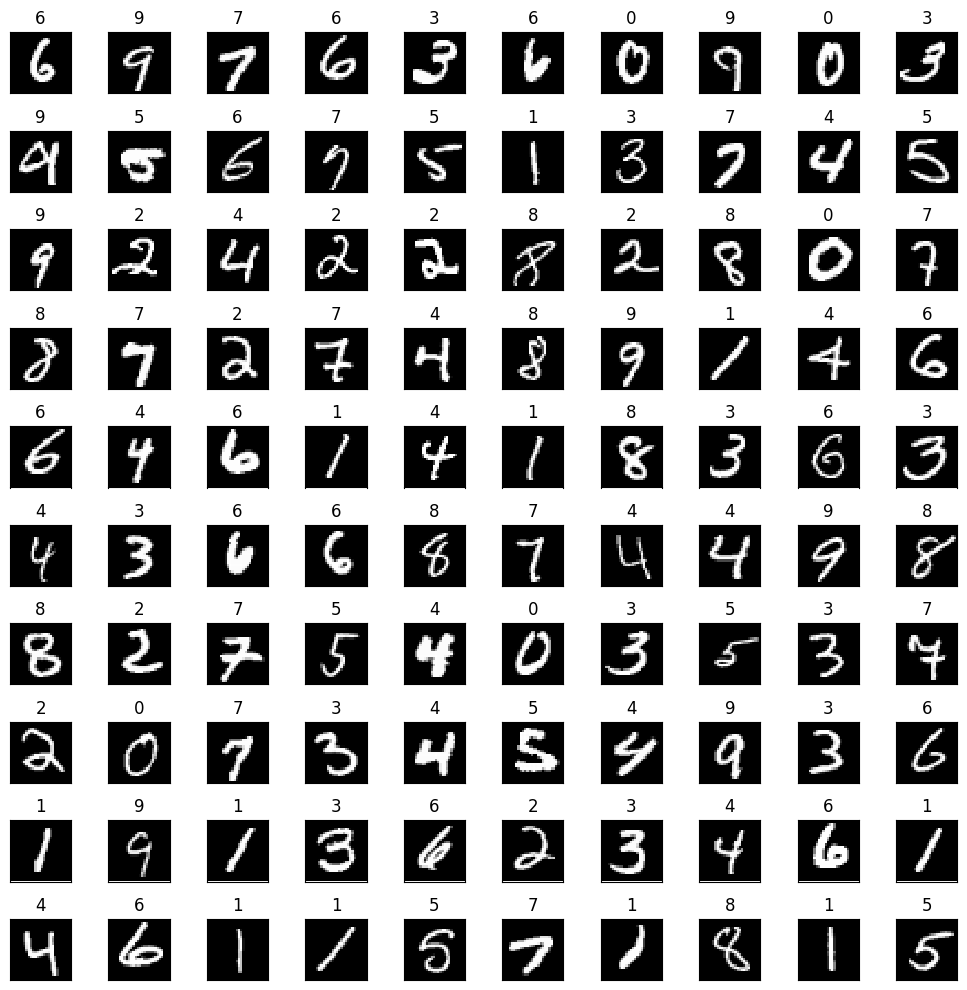

In [16]:
plot_mnist(sample_imgs, sample_labels)

## Training the CNN model

In [17]:
if useModel=='modelA':
    model = modelA
elif useModel == 'modelB':
    model = modelB
else:
    model = modelC

In [18]:
# to the compute device
model = model.to(device)

In [19]:
# Loss function
criterion = nn.CrossEntropyLoss()

# and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
print(f'===> use model: {useModel}')

===> use model: modelB


In [21]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):

    model.train()
    
    for i, (images, labels) in enumerate(train_loader):
        
        """PyTorch is channel first, different from TensorFlow!"""
        """images.size(): torch.Size([100, 1, 28, 28])"""
        
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward 
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.5543
Epoch [1/5], Step [200/600], Loss: 0.2473
Epoch [1/5], Step [300/600], Loss: 0.2694
Epoch [1/5], Step [400/600], Loss: 0.2619
Epoch [1/5], Step [500/600], Loss: 0.2041
Epoch [1/5], Step [600/600], Loss: 0.0951
Epoch [2/5], Step [100/600], Loss: 0.1124
Epoch [2/5], Step [200/600], Loss: 0.0783
Epoch [2/5], Step [300/600], Loss: 0.0731
Epoch [2/5], Step [400/600], Loss: 0.1028
Epoch [2/5], Step [500/600], Loss: 0.1027
Epoch [2/5], Step [600/600], Loss: 0.0489
Epoch [3/5], Step [100/600], Loss: 0.0853
Epoch [3/5], Step [200/600], Loss: 0.0893
Epoch [3/5], Step [300/600], Loss: 0.1024
Epoch [3/5], Step [400/600], Loss: 0.0240
Epoch [3/5], Step [500/600], Loss: 0.1399
Epoch [3/5], Step [600/600], Loss: 0.0596
Epoch [4/5], Step [100/600], Loss: 0.0536
Epoch [4/5], Step [200/600], Loss: 0.0575
Epoch [4/5], Step [300/600], Loss: 0.0904
Epoch [4/5], Step [400/600], Loss: 0.0241
Epoch [4/5], Step [500/600], Loss: 0.0434
Epoch [4/5], Step [600/600], Loss:

## Test the model with new data

In [22]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

# has effect on specific layers like Dropout and BatchNorm
with torch.no_grad():
    
    correct = 0
    total = 0

    # collect images/labels with wrong predictions
    true_image_list = []
    true_label_list = []
    wrong_label_list = []
    
    for idx, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        # prediction
        outputs = model(images)
        
        #Tensor.data: tensor
        _, predicted = torch.max(outputs.data, 1)  # (None, 10)
        
        #Tensor.size(): torch.Size, Tensor.size(0): int
        total += labels.size(0)
        
        #Tensor.item(): number
        correct += (predicted == labels).sum().item()

        # save images/labels that are wrong
        wrong = torch.asarray(predicted != labels).nonzero()
        if wrong.sum() > 0:
            
            aa = images[wrong]
            bb = labels[wrong]
            cc = predicted[wrong]
            
            # print('idx=', idx, aa.shape, bb.shape)
            
            true_image_list.append(aa)
            true_label_list.append(bb)
            wrong_label_list.append(cc)
        
    print(f'Test Accuracy of the model on the test images is {correct}/{total} = {100 * correct / total} %')

Test Accuracy of the model on the test images is 9867/10000 = 98.67 %


## Images with the wrong predictions

Here we list and show all the images with the wrong predictions.

In [23]:
true_images = torch.cat(true_image_list, dim=0).cpu().numpy().squeeze()
true_labels = torch.cat(true_label_list, dim=0).cpu().numpy().squeeze()
wrong_labels = torch.cat(wrong_label_list, dim=0).cpu().numpy().squeeze()

In [24]:
true_images.shape, wrong_labels.shape

((133, 28, 28), (133,))

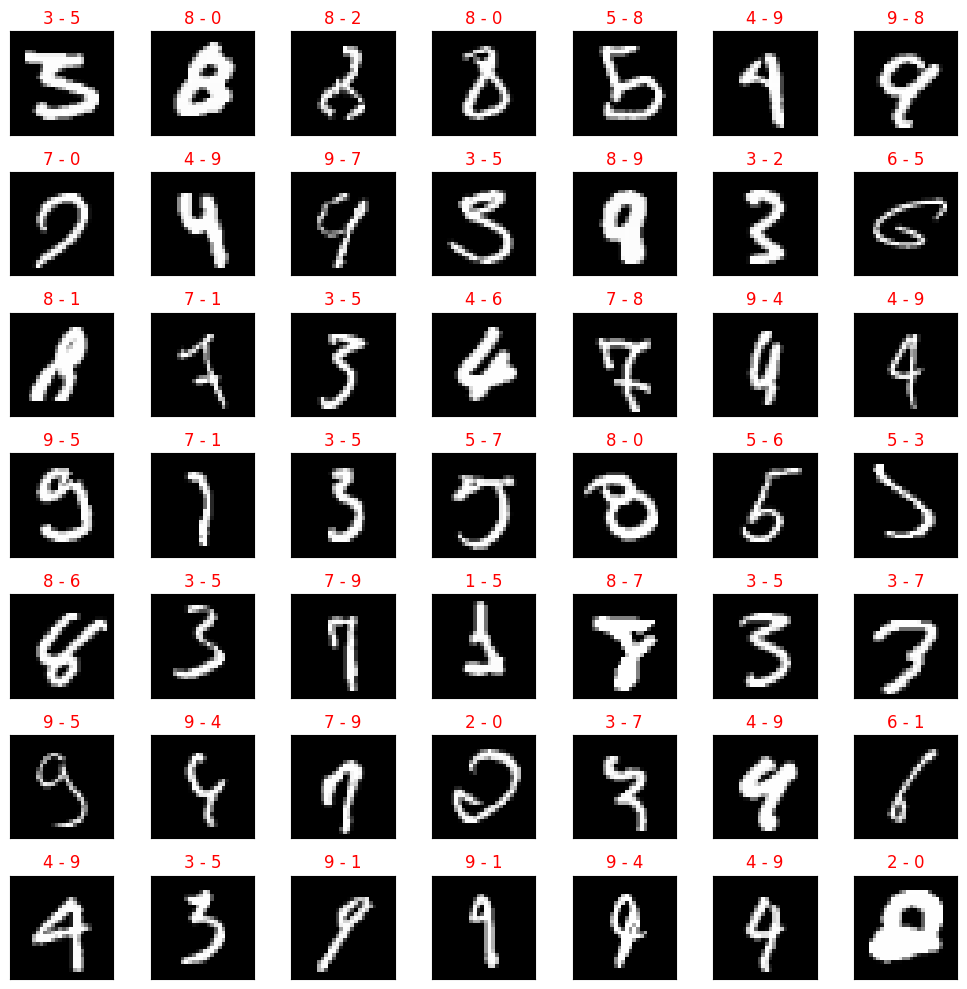

In [25]:
# extract some data for display
plot_mnist(true_images[:50], true_labels[:50], wrong_labels[:50])

## QC test data

Here we grab one batch of the test dataset and check the predictions.

In [26]:
def predict(model, images, labels):
    """ predict images
    """
    
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    
    # has effect on specific layers like Dropout and BatchNorm
    with torch.no_grad():
            
        images = images.to(device)
        labels = labels.to(device)
    
        # prediction
        outputs = model(images)
    
        #Tensor.data: tensor
        _, predicted = torch.max(outputs.data, 1)  # (None, 10)
    
        # batch size
        total = labels.size(0)
        
        #Tensor.item(): number
        correct = (predicted == labels).sum().item()
    
        print(f'**** The accuracy is {correct}/{total} = {correct/total*100} %')

    return predicted

In [27]:
# iterator for the test data
test_iter = iter(test_loader)

In [28]:
# grab one batch
images, labels = next(test_iter)

In [29]:
# do the prediction
predicted = predict(model, images, labels)

**** The accuracy is 100/100 = 100.0 %


In [30]:
# to the cpu
images = images.detach().cpu().numpy().squeeze()  # remove channel
labels = labels.detach().cpu().numpy()
predicted = predicted.detach().cpu().numpy()

In [31]:
images.shape, labels.shape, predicted.shape

((100, 28, 28), (100,), (100,))

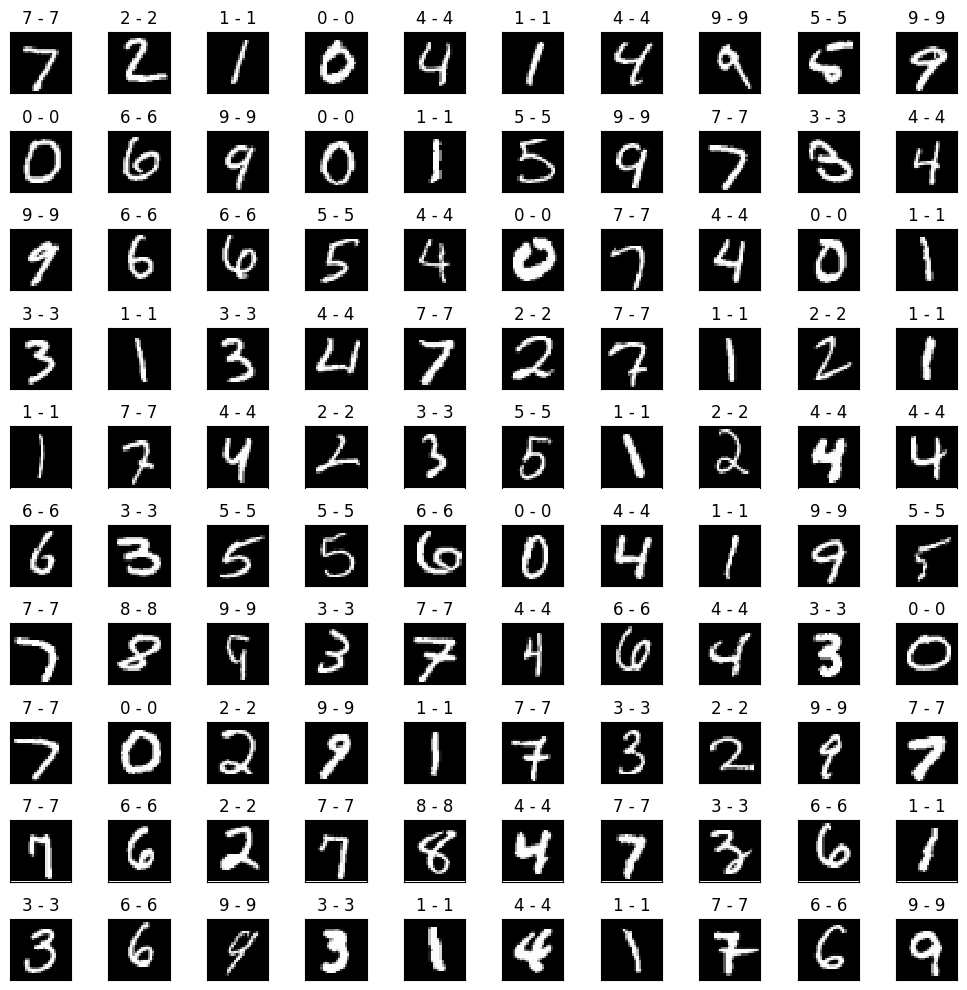

In [32]:
# extract some data for display
plot_mnist(images, labels, predicted)

## Save the model to disk

In [33]:
# Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')